<a href="https://colab.research.google.com/github/Ikeda33/codespaces-railstutorial/blob/main/vit_withse_50epoch_flower_D_v_G_sa_FID_KID_devide_1_color_relativistic1_hinge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#パッケージのダウンロード


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import argparse

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

In [ ]:
import torchvision.transforms as transforms

In [ ]:
import torchvision.datasets as dset

In [ ]:
import torchvision.utils as vutils

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tqdm

In [ ]:
import glob

In [ ]:
from torch.utils.data import Dataset
from PIL import Image

In [ ]:
from torch.utils.data import DataLoader
import torchvision

In [ ]:
!pip install torchmetrics
!pip install torchmetrics[image]

!pip install torch-fidelity

from torchmetrics.image.inception import InceptionScore


import torchmetrics
import torch_fidelity

import torch
_ = torch.manual_seed(123)
from torchmetrics.image.fid import FrechetInceptionDistance
fid = FrechetInceptionDistance(feature=2048)

from torchmetrics.image.kid import KernelInceptionDistance


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 14.1 MB/s eta 0:00:00


Downloading: "https://github.com/toshas/torch-fidelity/releases/download/v0.2.0/weights-inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/weights-inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:00<00:00, 490MB/s]


In [ ]:
kid = KernelInceptionDistance(subset_size=15)

/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `Kernel Inception Distance` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)  # noqa: B028


In [ ]:
#ハイパーパラメータの設定

In [ ]:
parser = argparse.ArgumentParser()
parser.add_argument("--n_epoch", type = int, default=50)
parser.add_argument("--batch_size", type = int, default=32)
parser.add_argument("--lr_g", type = float, default=2e-4)
parser.add_argument("--lr_d", type = float, default=3e-4)
parser.add_argument("--nch_g", type = int, default=64)
parser.add_argument("--nch_d", type = int, default=64)
parser.add_argument("--z_dim", type = int, default=100)
parser.add_argument("--beta1", type = float, default=0.5)

opt = parser.parse_args(args=[])
print(opt)

Namespace(n_epoch=50, batch_size=32, lr_g=0.0002, lr_d=0.0003, nch_g=64, nch_d=64, z_dim=100, beta1=0.5)


In [ ]:
class ImageDataset(Dataset):
    def __init__(self,  transform = None):
        super().__init__()
        self.file_list = glob.glob("/content/drive/MyDrive/102flowers (2)/jpg/*.jpg")#/content/drive/MyDrive/img_align_celeba.zip
        #self.file_list = glob.glob("/content/drive/MyDrive/cityscapes/cityscapes_data/train/*.jpg" )#/content/drive/MyDrive/cityscapes/cityscapes_data/train
        #self.file_list = glob.glob("/content/drive/MyDrive/Test/**/*.jpg" )#fruits
       # self.file_list = glob.glob("/content/drive/MyDrive/img_align_celeba.zip/jpg/*.jpg")#C:\Users\ikeda\Downloads\img_align_celeba\img_align_celeba
        #self.file_list = glob.glob("/content/drive/MyDrive/–¢Šm”F 758452(1).crdownload/*.jpg")
        self.transform = transform


    def __getitem__(self, index):
        if self.transform is not None:
            img = self.transform(Image.open(self.file_list[index]))
        else:
            img = Image.open(self.file_list[index])
        return img

    def __len__(self):
        return len(self.file_list)

In [ ]:
from torchvision.transforms.transforms import CenterCrop

transform = transforms.Compose([

    transforms.Resize(80),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
                               transforms.Normalize((0.5,),(0.5,))])

In [ ]:
#dataset = dset.MNIST("./", train = True, download = True,transform = transform)
dataset = ImageDataset(transform = transform)
#dataset = torchvision.datasets.CelebA("./", split = "test", download = True,transform = transform) #Cityscapes
#dataset = torchvision.datasets.Cityscapes("C:\Users\ikeda\Downloads\cityscapes\cityscapes_data\cityscapes_data", split='train', mode='fine', target_type='color')


In [ ]:
dataloader = DataLoader(dataset = dataset, batch_size = opt.batch_size,num_workers = 2,  shuffle = True)

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm") != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


In [ ]:
#モデルの設定

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        out_channels = in_channels
        self.conv1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv2 = nn.utils.spectral_norm(nn.Conv2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size -> チャネル数だけ変化させること
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.se_block_0 = SE(out_channels)
    def shortcut(self, x):
        x = self.conv3(x)
        x = self.bn(x)
        return x

    def forward(self, x):
        identity = x#入力
        x = self.conv1(x)
        x = self.se_block_0(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.se_block_0(x)
        x = self.bn(x)
        x = x + self.shortcut(identity)
        return x

In [ ]:
class ResidualBlock_G(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        out_channels = in_channels
        self.conv1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv2 = nn.utils.spectral_norm(nn.ConvTranspose2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size -> チャネル数だけ変化させること
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.se_block_0 = SE_G(out_channels)
    def shortcut(self, x):
        x = self.conv3(x)
        x = self.bn(x)
        return x

    def forward(self, x):
        identity = x#入力
        x = self.conv1(x)
        x = self.se_block_0(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.se_block_0(x)
        x = self.bn(x)
        x = x + self.shortcut(identity)
        return x

In [ ]:
class ResidualBlock_1(nn.Module):#実質パディングとスペクトラム正規化とインスタンス正規化
  def __init__(self, in_channels):
    super().__init__()
    self.conv_layers = nn.Sequential(
        nn.ReflectionPad2d(1),
        nn.utils.spectral_norm(nn.Conv2d(in_channels, in_channels, 3)),
        nn.InstanceNorm2d(in_channels),
        nn.ReLU(inplace = True),

        nn.ReflectionPad2d(1),
        nn.utils.spectral_norm(nn.Conv2d(in_channels, in_channels, 3)),
        nn.InstanceNorm2d(in_channels),

    )
  def forward(self, x):
    out = self.conv_layers(x)
    out = out + x
    return out

In [ ]:
class SelfAttention(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        n_divide = in_channels
        #out_channels = in_channels // n_divide
        out_channels = 1

        self.fx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#nn.utils.spectral_norm
        self.gx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#
        self.hx_1x1 = (nn.Conv2d(in_channels, in_channels, kernel_size = 1))#
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim = -2)#規格化するため -2


    def forward(self, x):
        B, C, H, W = x.size()
        #x = nn.LayerNorm([C,H,W])#input.size()[1:]
        fx = self.fx_1x1(x).view(B, -1, H*W).permute(0,2,1)
        gx = self.gx_1x1(x).view(B, -1, H*W)
        hx = self.hx_1x1(x).view(B, -1, H*W)

        s_mtx = torch.bmm(fx, gx)
        attention = self.softmax(s_mtx)

        o =torch.bmm(hx, attention)
        o = o.view(B, -1, H, W)
        out = x + self.gamma * o
        return out

In [ ]:
#import torch
#from layers.transformer.ScaledDotProductAttention import ScaledDotProductAttention
#from torch import nn


class MultiHeadAttention(nn.Module):
    def __init__(self, in_channels, h = 8):
        super().__init__()
        d_model = in_channels
        self.d_model = in_channels
        self.h = in_channels
        self.d_k = d_model // h
        self.d_v = d_model // h
        self.fx_1x1 = (nn.Conv2d(in_channels, in_channels//self.h, kernel_size = 1))
        self.gx_1x1 = (nn.Conv2d(in_channels, in_channels//self.h, kernel_size = 1))
        self.hx_1x1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, in_channels, kernel_size = 1))
        self.qkv = nn.utils.spectral_norm(nn.Conv2d(in_channels, 3 * in_channels, kernel_size = 1))

#        self.scaled_dot_product_attention = SelfAttention(self.d_model)

        self.linear = nn.Linear(self.h * self.d_v, d_model)
       # self.fx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#nn.utils.spectral_norm
        #self.gx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#
        #self.hx_1x1 = (nn.Conv2d(in_channels, in_channels, kernel_size = 1))#
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim = -2)#規格化するため -2

        self.se_block_0 = SE(in_channels)
        self.relu = nn.ReLU()

    def forward(self, x ) -> torch.Tensor:
        B, C, H, W = x.size()
        qkv = self.qkv(x)
        self.q, self.k, self.v = qkv.chunk(3, dim = 1)

        #self.q = self.se_block_0(self.q)
        #self.k = self.se_block_0(self.k)
        #self.v = self.se_block_0(self.v)

        """Scaled dot product attention"""
       # attention_output = self.scaled_dot_product_attention(self.q, self.k, self.v)  # (head*batch_size, seq_len, d_model)
        B, C, H, W = self.q.size()
        #x = nn.LayerNorm([C,H,W])#input.size()[1:]
        fx = self.fx_1x1(self.q).view(B, -1, H*W).permute(0,2,1)
        gx = self.gx_1x1(self.k).view(B, -1, H*W)
        hx = self.hx_1x1(self.v).view(B, -1, H*W)
       # fx = self.q.view(B, -1, H*W).permute(0,2,1)
       # gx = self.k.view(B, -1, H*W)
       # hx = self.v.view(B, -1, H*W)

        s_mtx = torch.bmm(fx, gx)
        attention = self.softmax(s_mtx)

        o =torch.bmm(hx, attention)
        o = o.view(B, -1, H, W)
        out = x + self.gamma * o

        #out = out.repeat(1,self.h*1,1,1)

        #out = torch.chunk(out, self.h, dim=1)
       # out = torch.cat(out, dim=1)

        """Linear after scaled dot product attention"""
        #output = self.linear(out)
        return out


In [ ]:

class MultiHeadAttention_G(nn.Module):
    def __init__(self, in_channels, h = 8):
        super().__init__()
        d_model = in_channels
        self.d_model = in_channels
        self.h = in_channels
        self.d_k = d_model // h
        self.d_v = d_model // h
        self.fx_1x1 = (nn.ConvTranspose2d(in_channels, in_channels//self.h, kernel_size = 1))
        self.gx_1x1 = (nn.ConvTranspose2d(in_channels, in_channels//self.h, kernel_size = 1))
        self.hx_1x1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, in_channels, kernel_size = 1))
        self.qkv = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, 3 * in_channels, kernel_size = 1))

#        self.scaled_dot_product_attention = SelfAttention(self.d_model)

        self.linear = nn.Linear(self.h * self.d_v, d_model)
       # self.fx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#nn.utils.spectral_norm
        #self.gx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#
        #self.hx_1x1 = (nn.Conv2d(in_channels, in_channels, kernel_size = 1))#
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim = -2)#規格化するため -2

        self.se_block_0 = SE_G(in_channels)
        self.relu = nn.ReLU()

    def forward(self, x ) -> torch.Tensor:
        B, C, H, W = x.size()
        qkv = self.qkv(x)
        qkv = self.relu(qkv)
        self.q, self.k, self.v = qkv.chunk(3, dim = 1)

        #self.q = self.se_block_0(self.q)
        #self.k = self.se_block_0(self.k)
        #self.v = self.se_block_0(self.v)
        """Scaled dot product attention"""
       # attention_output = self.scaled_dot_product_attention(self.q, self.k, self.v)  # (head*batch_size, seq_len, d_model)
        B, C, H, W = self.q.size()
        #x = nn.LayerNorm([C,H,W])#input.size()[1:]
        fx = self.fx_1x1(self.q).view(B, -1, H*W).permute(0,2,1)
        gx = self.gx_1x1(self.k).view(B, -1, H*W)
        hx = self.hx_1x1(self.v).view(B, -1, H*W)
       # fx = self.q.view(B, -1, H*W).permute(0,2,1)
       # gx = self.k.view(B, -1, H*W)
       # hx = self.v.view(B, -1, H*W)

        s_mtx = torch.bmm(fx, gx)
        attention = self.softmax(s_mtx)

        o =torch.bmm(hx, attention)
        o = o.view(B, -1, H, W)
        out = x + self.gamma * o

        #out = out.repeat(1,self.h*1,1,1)

        #out = torch.chunk(out, self.h, dim=1)
       # out = torch.cat(out, dim=1)

        """Linear after scaled dot product attention"""
        #output = self.linear(out)
        return out

In [ ]:
class SelfAttention_G(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        n_divide = in_channels
        out_channels = in_channels // n_divide
      #  out_channels = 1

        self.fx_1x1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels, kernel_size = 1))
        self.gx_1x1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels, kernel_size = 1))
        self.hx_1x1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, in_channels, kernel_size = 1))
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim = -2)#規格化するため -2


    def forward(self, x):
        B, C, H, W = x.size()
        fx = self.fx_1x1(x).view(B, -1, H*W).permute(0,2,1)
        gx = self.gx_1x1(x).view(B, -1, H*W)
        hx = self.hx_1x1(x).view(B, -1, H*W)

        s_mtx = torch.bmm(fx, gx)
        attention = self.softmax(s_mtx)

        o =torch.bmm(hx, attention)
        o = o.view(B, -1, H, W)
        out = x + self.gamma * o
        return out

In [ ]:
class PF(nn.Module):#poolformer
    def __init__(self, in_channels , out_channels):
        super().__init__()
        self.conv1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size=3, padding=1))#kernel_size=4, stride=2, padding=1
        self.conv2 = nn.utils.spectral_norm(nn.Conv2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size -> チャネル数だけ変化させること
        self.pre_bn = nn.BatchNorm2d(in_channels)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.pool = nn.AvgPool2d(kernel_size = 3, stride = 1, padding = 3//2, count_include_pad=False)
        self.flat = nn.Flatten()
    def shortcut(self, x):
        x = self.conv3(x)
        x = self.bn(x)
        return x

    def forward(self, x):
        identity = x#入力
        x = self.pre_bn(x)
        x = self.pool(x) -x
        x = x + identity

        identity = x#入力
        x = self.pre_bn(x)
        x= self.flat(x)
        x = self.conv1(x)
        x = self.relu(x)
        x = x + self.shortcut(identity)
        return x

In [ ]:
"""    def __init__(self, in_channels):
        super().__init__()
        n_divide = 8
        out_channels = in_channels // n_divide
        self.dim = 3

        self.fx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#nn.utils.spectral_norm
        self.gx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#
        self.hx_1x1 = (nn.Conv2d(in_channels, in_channels, kernel_size = 1))#
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim = -2)#規格化するため -2
        self.conv1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size=3, padding=1))#kernel_size=4, stride=2, padding=1
        self.conv2 = nn.utils.spectral_norm(nn.Conv2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size==1 -> チャネル数だけ変化させること
        self.pre_bn = nn.BatchNorm2d(in_channels)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.pool= nn.AvgPool2d(kernel_size =self.dim , stride = 1, padding = 0, count_include_pad=False)
        self.sigmoid = nn.Sigmoid()


    def forward(self, x):
        B, C, H, W = x.size()
        z = self.pre_bn(x)
        z = self.pool(z, self.dim = H)

        z = self.conv1(z)
        z = self.relu(z)

        z = self.conv2(z)
        z = self.sigmoid(z)

        z = torch.einsum("bchw,bchw->bchw",(x, z))
        out = x + self.gamma * z
        return out
"""

'    def __init__(self, in_channels):\n        super().__init__()\n        n_divide = 8\n        out_channels = in_channels // n_divide\n        self.dim = 3\n\n        self.fx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#nn.utils.spectral_norm\n        self.gx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#\n        self.hx_1x1 = (nn.Conv2d(in_channels, in_channels, kernel_size = 1))#\n        self.gamma = nn.Parameter(torch.zeros(1))\n        self.softmax = nn.Softmax(dim = -2)#規格化するため -2\n        self.conv1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size=3, padding=1))#kernel_size=4, stride=2, padding=1\n        self.conv2 = nn.utils.spectral_norm(nn.Conv2d(out_channels, out_channels,kernel_size = 3, padding = 1))\n        self.conv3 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size==1 -> チャネル数だけ変化させること\n        self.pre_bn = nn.BatchNorm2d(in_channels)\n        self.bn = n

In [ ]:
class SE(nn.Module):#SE_Block layerに対して作用するattentionのようなモデル
    def __init__(self, in_channels, reduction=24):
        super().__init__()
        channel = in_channels
        reduction = in_channels
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
           # nn.Linear(channel, channel// reduction , bias=False),
            (nn.Conv2d(in_channels, in_channels// reduction,kernel_size = 1, padding = 0)),
            nn.ReLU(inplace=True),
            #nn.Linear(channel // reduction, channel, bias=False),
            (nn.Conv2d(in_channels// reduction,in_channels,kernel_size = 1, padding = 0)),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        #y = self.avg_pool(x).view(b, c)
        y = self.avg_pool(x)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)




In [ ]:
class SE_G(nn.Module):#SE_Block layerに対して作用するattentionのようなモデル
    def __init__(self, in_channels, reduction=24):
        super().__init__()
        channel = in_channels
        reduction = in_channels
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            #nn.Linear(channel, channel// reduction , bias=False),
            nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, in_channels// reduction,kernel_size = 1, padding = 0)),
            nn.ReLU(inplace=True),
            #nn.Linear(channel // reduction, channel, bias=False),
            nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels// reduction,in_channels,kernel_size = 1, padding = 0)),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

In [ ]:
#nn.ConvTranspose2d
class PF_G(nn.Module):#poolformer
    def __init__(self, in_channels , out_channels):
        super().__init__()
        self.conv1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels,kernel_size=3, padding=1))
        self.conv2 = nn.utils.spectral_norm(nn.ConvTranspose2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size -> チャネル数だけ変化させること
        self.pre_bn = nn.BatchNorm2d(in_channels)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.pool = nn.AvgPool2d(kernel_size = 3, stride = 1, padding = 3//2, count_include_pad=False)
        self.flat = nn.Flatten()
    def shortcut(self, x):
        x = self.conv3(x)
        x = self.bn(x)
        return x

    def forward(self, x):
        identity = x#入力
        x = self.pre_bn(x)
        x = self.pool(x) - x
        x = x + identity

        identity = x#入力
        x = self.pre_bn(x)
        x = self.flat(x)
        x = self.conv1(x)
        x = self.relu(x)
        x = x + self.shortcut(identity)
        return x

In [ ]:
"""(((W - K + 2P)/S) + 1)
    Here W = Input size
    K = Filter size
    S = Stride
    P = Padding
    ((Input_size-kernel_size + 2*Padding)/stride)+ 1
    この式を使用できます[(W−K+2P)/S]+1。

W は入力ボリュームです - あなたの場合は 128
Kはカーネルサイズです - あなたの場合は5です
P はパディングです - あなたの場合は 0 だと思います
S はストライドです - あなたが提供していません。
したがって、次の式に入力します。
for example
Output_Shape = (128-5+0)/1+1

Output_Shape = (124,124,40)
output==1 ,1  = (W - k + 2p)/s = 0   s = 1, p = 0 ,k = W
    """



'(((W - K + 2P)/S) + 1)\n    Here W = Input size\n    K = Filter size\n    S = Stride\n    P = Padding\n    ((Input_size-kernel_size + 2*Padding)/stride)+ 1\n    この式を使用できます[(W−K+2P)/S]+1。\n\nW は入力ボリュームです - あなたの場合は 128\nKはカーネルサイズです - あなたの場合は5です\nP はパディングです - あなたの場合は 0 だと思います\nS はストライドです - あなたが提供していません。\nしたがって、次の式に入力します。\nfor example\nOutput_Shape = (128-5+0)/1+1\n\nOutput_Shape = (124,124,40)\noutput==1 ,1  = (W - k + 2p)/s = 0   s = 1, p = 0 ,k = W\n    '

In [ ]:
class VIT(nn.Module):
    def __init__(self, in_channels , out_channels):
        super().__init__()
        self.conv1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size=3, padding=1))
        self.conv2 = nn.utils.spectral_norm(nn.Conv2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size -> チャネル数だけ変化させること
        self.bn = nn.BatchNorm2d(out_channels)
        self.pre_bn = nn.BatchNorm2d(in_channels)

        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size = 3, stride = 1, padding = 3//2)
        self.attention = SelfAttention(in_channels)
        self.se_block_0 = SE(in_channels)
        self.se_block_1 = SE(out_channels)

        self.flat = nn.Flatten()

        self.linear_1 = nn.Linear(32,64, bias=False)
        self.linear_2 = nn.Linear( 32,32, bias=False)#if ( 64,32, bias=False)  -> mat1 and mat2 shapes cannot be multiplied (131072x32 and 64x32)


    def shortcut(self, x):
        x = self.conv3(x)
        #x = self.se_block_1(x)
        x = self.bn(x)
        return x

    def forward(self, x):

        identity = x#入力
        x = self.pre_bn(x)
        x = self.se_block_0(x)
       # x = self.attention(x) - x
        x = x + identity


        identity = x#入力
        x = self.pre_bn(x)
       # b, c, h, w = x.size()
        x = self.conv1(x)


      #  x = self.linear_1(x).view(b, -1, h, w)
        x = self.relu(x)
       # x = self.linear_2(x).view(b, -1, h, w)


        x =  self.shortcut(identity) + x
        #x = x + self.shortcut(identity)
        x = self.bn(x)

        return x

In [ ]:
#nn.ConvTranspose2d
class VIT_G(nn.Module):
    def __init__(self, in_channels , out_channels):
        super().__init__()
        self.conv1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels,kernel_size=3, padding=1))
        self.conv2 = nn.utils.spectral_norm(nn.ConvTranspose2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size=1 -> チャネル数だけ変化させること
        self.bn = nn.BatchNorm2d(out_channels)
        self.pre_bn = nn.BatchNorm2d(in_channels)
        self.relu = nn.ReLU()
        self.pool = nn.AvgPool2d(kernel_size = 3, stride = 1, padding = 3//2, count_include_pad=False)
        self.attention = MultiHeadAttention_G(in_channels)

    def shortcut(self, x):
        x = self.conv3(x)
        x = self.bn(x)
        return x

    def forward(self, x):
        identity = x#入力
        x = self.pre_bn(x)
        x = self.attention(x) - x
        x = x + identity

        #identity = x#入力
        x = self.pre_bn(x)
        x = self.conv1(x)
        x = self.relu(x)
        x = x + self.shortcut(identity)
        return x

In [ ]:
class Generator(nn.Module):
    def __init__(self,pf, vit, resnet,res_net,sa,z_dim = opt.z_dim, ngf = opt.nch_g, nc = 3):# ものくろだからnc=1 カラーならnc=3
        super().__init__()

        self.convt1 = self.conv_trans_layers(z_dim, 8*ngf, 4,1,0 )# ngf = the number of channels

        self.convt2 = self.conv_trans_layers(8*ngf, 4*ngf, 4, 2, 1 )
        self.convt3 = self.conv_trans_layers(4*ngf,  2*ngf, 4,2,1)
        self.convt4 = self.conv_trans_layers(2*ngf,  ngf, 4,2,1 )

        self.pf1 = pf(z_dim, 8*ngf)
        self.vit1 = vit(z_dim, 8*ngf)

        self.pf2 = pf(8*ngf, 4*ngf)
        self.vit2 = vit(8*ngf, 4*ngf)

        self.pf3 = pf(4*ngf,  2*ngf)
        self.vit3 = vit(4*ngf,  2*ngf)

        self.pf4 = pf(2*ngf,  ngf)
        self.vit4 = vit(2*ngf,  ngf)

        self.convt5 = nn.Sequential(
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1),
            #self.conv_trans_layers(ngf, nc, 4,2,1  )
            nn.Tanh()
        )


    @staticmethod
    def conv_trans_layers(in_channels, out_channels, kernel_size, stride, padding, has_norm=True,attention=True, res_net= False, se = False):
        layers = [nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding))]#spectralnorm
        if has_norm:
            layers.append(nn.BatchNorm2d(out_channels))
        #layers.append(nn.ReLU(inplace = True))
        layers.append(nn.LeakyReLU(0.2, inplace = True))
        if se:
            layers.append(SE_G(out_channels))
        if attention:
            layers.append(SelfAttention_G(out_channels))
        if res_net:
            layers.append(ResidualBlock_G(out_channels))



        net = nn.Sequential(*layers)#listのアンパック

        return net

    def forward(self, x):
        out = self.convt1(x)

        out = self.convt2(out)

        out = self.convt3(out)

        out = self.convt4(out)

        out = self.convt5(out)


        return out

In [ ]:
from pickle import FALSE
class Discriminator(nn.Module):
    def __init__(self,pf,vit ,resnet,res_net,sa,nc = 3, ndf = opt.nch_d):# ものくろだからnc=1 カラーならnc=3
        super().__init__()
        self.conv1 = self.conv_layers(nc, ndf)
        self.pf1 = pf(nc,ndf)
        self.vit1 = vit(nc,ndf)

        self.conv2 = self.conv_layers(ndf, 2*ndf )
        self.pf2 = pf(ndf, 2*ndf)
        self.vit2 = vit(ndf, 2*ndf)

        self.conv3 = self.conv_layers(2*ndf, 4*ndf )
        self.pf3 = pf(2*ndf, 4*ndf )
        self.vit3 = vit(2*ndf, 4*ndf )

        self.conv4 = self.conv_layers(4*ndf, 8*ndf)
        self.pf4 = pf(4*ndf, 8*ndf)
        self.vit4 = vit(4*ndf, 8*ndf)

        self.vit5 = vit(8*ndf, 16*ndf)

        self.conv5 =  nn.Conv2d(8*ndf, 1,  4)
        #self.conv6 =  nn.Conv2d(16*ndf, 1,  4)


    @staticmethod
    def conv_layers(in_channels, out_channels, kernel_size=4, stride=2, padding=1, has_batch_norm = True, attention = False, res_net = False, se = False):
        layers = [nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding))]
        if has_batch_norm:
            layers.append(nn.BatchNorm2d(out_channels))
        layers.append(nn.LeakyReLU(0.2, inplace = True))
        if se:
            layers.append(SE(out_channels))
        if attention:
            layers.append(SelfAttention(out_channels))

        if res_net:
            layers.append(ResidualBlock(out_channels))


        net = nn.Sequential(*layers)#listのアンパック

        return net

    def forward(self, x):
        out = self.conv1(x)

        out = self.vit2(out)

        out = self.vit3(out)

        out = self.vit4(out)

        out = self.conv5(out)

        return out

In [ ]:
#モデルのトレーニング

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
device

device(type='cuda')

In [ ]:
netG = Generator(PF_G,VIT_G,ResidualBlock,ResidualBlock_1,SelfAttention, z_dim=opt.z_dim , ngf=opt.nch_g ).to(device)
netG.apply(weights_init)
print(netG)

netD = Discriminator(PF,VIT,ResidualBlock,ResidualBlock_1,SelfAttention, nc = 3 , ndf=opt.nch_d ).to(device)# ものくろだからnc=1 カラーならnc=3
netD.apply(weights_init)
print(netD)

Generator(
  (convt1): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): SelfAttention_G(
      (fx_1x1): ConvTranspose2d(512, 1, kernel_size=(1, 1), stride=(1, 1))
      (gx_1x1): ConvTranspose2d(512, 1, kernel_size=(1, 1), stride=(1, 1))
      (hx_1x1): ConvTranspose2d(512, 512, kernel_size=(1, 1), stride=(1, 1))
      (softmax): Softmax(dim=-2)
    )
  )
  (convt2): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): SelfAttention_G(
      (fx_1x1): ConvTranspose2d(256, 1, kernel_size=(1, 1), stride=(1, 1))
      (gx_1x1): ConvTranspose2d(256, 1, kernel_size=(1, 1), stride=(1, 1))
      (hx_1x1): ConvTranspo

In [ ]:
#criterion = nn.BCELoss()
#criterion = torch.nn.HingeEmbeddingLoss()
optimizerG = optim.Adam(netG.parameters(), lr = opt.lr_g, betas= (opt.beta1, 0.999), weight_decay = 1e-5)
optimizerD = optim.Adam(netD.parameters(), lr = opt.lr_d, betas= (opt.beta1, 0.999), weight_decay = 1e-5)

100%|██████████| 103/103 [01:30<00:00,  1.14it/s]


epoch: 0, lossD:1.3788425002283262, lossG:4.213198182652298,lossG_fake:2.0004401461591996, lossG_real:2.2127580376504694 ,equality:-0.21231789149126978


evaluate:149.8373260498047,kid_mean:0.09169062972068787, kid_std:0.021644052118062973,kid_:(tensor(0.0917), tensor(0.0216))


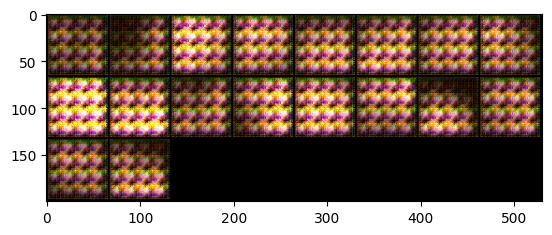

100%|██████████| 103/103 [00:32<00:00,  3.14it/s]


epoch: 1, lossD:1.4929454176171313, lossG:3.178743908706221,lossG_fake:1.76081085783764, lossG_real:1.4179330421882925 ,equality:0.3428778156493475


evaluate:141.19635009765625,kid_mean:0.09988334029912949, kid_std:0.0378865972161293,kid_:(tensor(0.0999), tensor(0.0379))


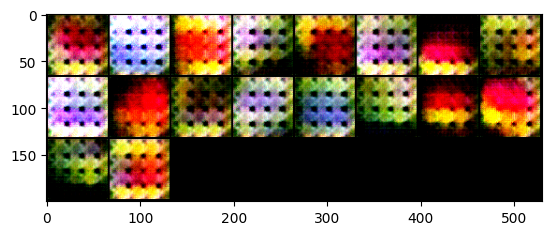

100%|██████████| 103/103 [00:34<00:00,  3.02it/s]


epoch: 2, lossD:1.7082934749936594, lossG:2.6203167901455777,lossG_fake:1.4372344491551223, lossG_real:1.183082343305199 ,equality:0.2541521058499234


evaluate:128.71905517578125,kid_mean:0.0801520049571991, kid_std:0.04041433706879616,kid_:(tensor(0.0802), tensor(0.0404))


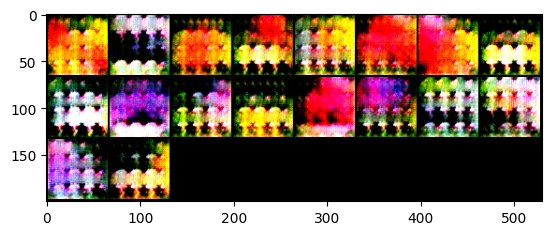

100%|██████████| 103/103 [00:33<00:00,  3.06it/s]


epoch: 3, lossD:1.7357583161696648, lossG:2.5643159579304817,lossG_fake:1.3879841924871055, lossG_real:1.176331756184402 ,equality:0.21165243630270347


evaluate:131.01719665527344,kid_mean:0.08645887672901154, kid_std:0.038654714822769165,kid_:(tensor(0.0865), tensor(0.0387))


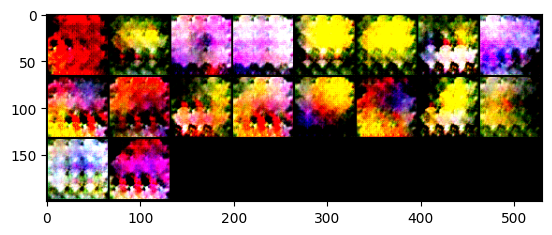

100%|██████████| 103/103 [00:33<00:00,  3.04it/s]


epoch: 4, lossD:1.8064976768586243, lossG:2.475832605824887,lossG_fake:1.3483496024770645, lossG_real:1.1274830131854825 ,equality:0.22086658929158198


evaluate:121.3053970336914,kid_mean:0.08045686036348343, kid_std:0.03462456539273262,kid_:(tensor(0.0805), tensor(0.0346))


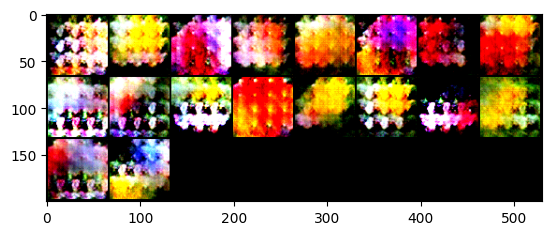

100%|██████████| 103/103 [00:33<00:00,  3.05it/s]


epoch: 5, lossD:1.7803305341202078, lossG:2.4849505262467466,lossG_fake:1.3382079936925648, lossG_real:1.1467425394984125 ,equality:0.19146545419415228


evaluate:124.120361328125,kid_mean:0.08186931908130646, kid_std:0.04092193394899368,kid_:(tensor(0.0819), tensor(0.0409))


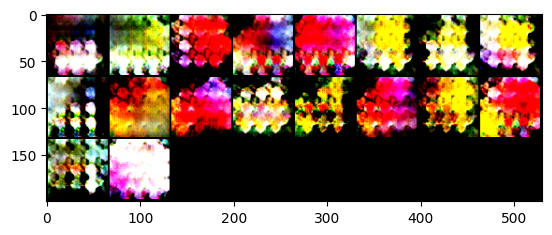

100%|██████████| 103/103 [00:33<00:00,  3.05it/s]


epoch: 6, lossD:1.7972629336477484, lossG:2.490030716923834,lossG_fake:1.32702094953037, lossG_real:1.163009767393464 ,equality:0.1640111821369059


evaluate:114.15423583984375,kid_mean:0.08251018822193146, kid_std:0.048276614397764206,kid_:(tensor(0.0825), tensor(0.0483))


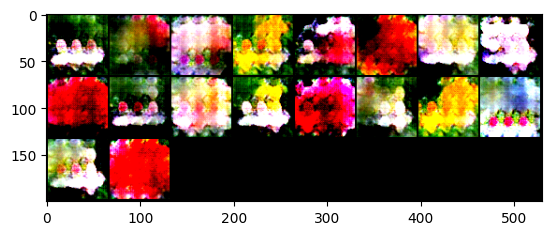

100%|██████████| 103/103 [00:33<00:00,  3.05it/s]


epoch: 7, lossD:1.8078788449463334, lossG:2.4432018821679273,lossG_fake:1.2853956500303398, lossG_real:1.1578062315589015 ,equality:0.12758941847143834


evaluate:118.43301391601562,kid_mean:0.0777348205447197, kid_std:0.03155313804745674,kid_:(tensor(0.0777), tensor(0.0316))


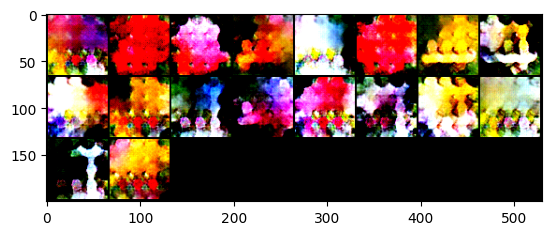

100%|██████████| 103/103 [00:33<00:00,  3.06it/s]


epoch: 8, lossD:1.8771121779691826, lossG:2.40806492786963,lossG_fake:1.2714878557955178, lossG_real:1.1365770720741124 ,equality:0.13491078372140541


evaluate:117.5782699584961,kid_mean:0.06824536621570587, kid_std:0.033007338643074036,kid_:(tensor(0.0682), tensor(0.0330))


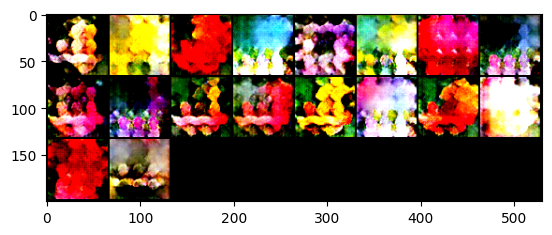

100%|██████████| 103/103 [00:33<00:00,  3.05it/s]


epoch: 9, lossD:1.8189955915062173, lossG:2.3975602122186457,lossG_fake:1.2613236730538526, lossG_real:1.136236530484505 ,equality:0.1250871425693476


evaluate:117.40689849853516,kid_mean:0.08182437717914581, kid_std:0.03539051488041878,kid_:(tensor(0.0818), tensor(0.0354))


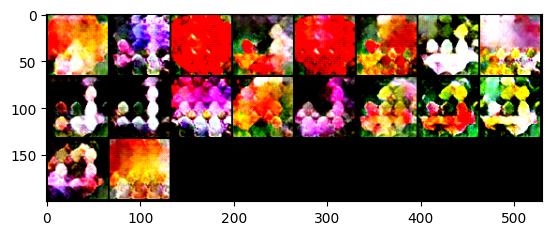

100%|██████████| 103/103 [00:33<00:00,  3.04it/s]


epoch: 10, lossD:1.8662535403538676, lossG:2.382507553378355,lossG_fake:1.2484594201578678, lossG_real:1.1340481337991732 ,equality:0.11441128635869457


evaluate:116.86787414550781,kid_mean:0.07716518640518188, kid_std:0.03762166574597359,kid_:(tensor(0.0772), tensor(0.0376))


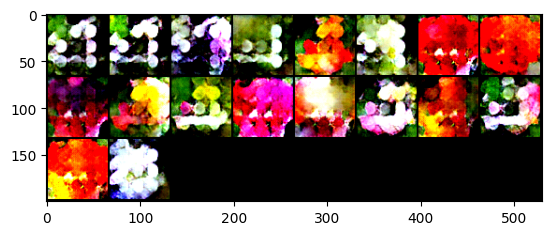

100%|██████████| 103/103 [00:33<00:00,  3.04it/s]


epoch: 11, lossD:1.8571079587473454, lossG:2.3493437373522417,lossG_fake:1.2215885276933318, lossG_real:1.1277551986638783 ,equality:0.09383332902945352


evaluate:119.13311767578125,kid_mean:0.07509498298168182, kid_std:0.03975888341665268,kid_:(tensor(0.0751), tensor(0.0398))


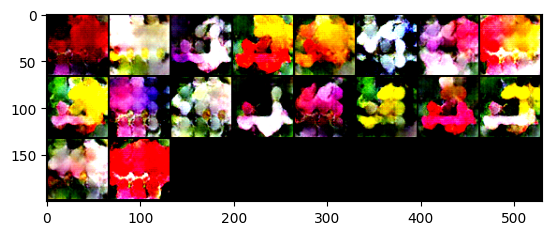

100%|██████████| 103/103 [00:33<00:00,  3.04it/s]


epoch: 12, lossD:1.9781483550673549, lossG:2.4311957752820357,lossG_fake:1.2741747949887248, lossG_real:1.1570209623540488 ,equality:0.11715383263467594


evaluate:118.64434814453125,kid_mean:0.0875774547457695, kid_std:0.04531678557395935,kid_:(tensor(0.0876), tensor(0.0453))


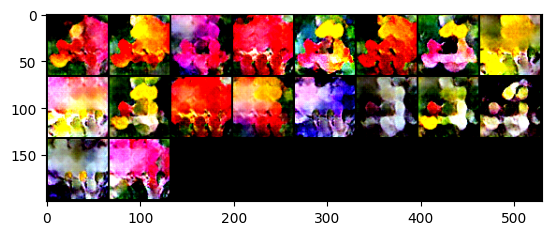

100%|██████████| 103/103 [00:33<00:00,  3.05it/s]


epoch: 13, lossD:1.83927124912299, lossG:2.2785183619526985,lossG_fake:1.168492849590709, lossG_real:1.1100255112046178 ,equality:0.058467338386091194


evaluate:119.7644271850586,kid_mean:0.09050960838794708, kid_std:0.04706842824816704,kid_:(tensor(0.0905), tensor(0.0471))


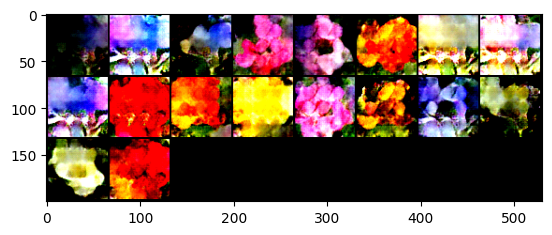

100%|██████████| 103/103 [00:33<00:00,  3.05it/s]


epoch: 14, lossD:1.8840384437042532, lossG:2.3389095473058017,lossG_fake:1.2017774824957246, lossG_real:1.1371320763837944 ,equality:0.06464540611193015


evaluate:121.1388168334961,kid_mean:0.07986893504858017, kid_std:0.039843346923589706,kid_:(tensor(0.0799), tensor(0.0398))


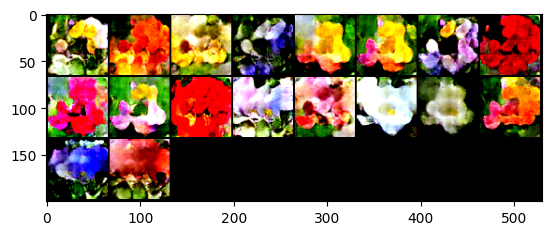

100%|██████████| 103/103 [00:33<00:00,  3.05it/s]


epoch: 15, lossD:1.8507590895717583, lossG:2.3042640107349284,lossG_fake:1.1915334139055418, lossG_real:1.1127305893064703 ,equality:0.07880282459907151


evaluate:121.03225708007812,kid_mean:0.0895746499300003, kid_std:0.042240023612976074,kid_:(tensor(0.0896), tensor(0.0422))


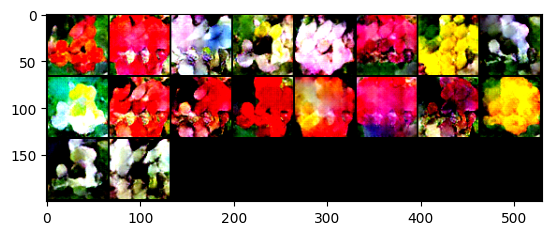

100%|██████████| 103/103 [00:33<00:00,  3.05it/s]


epoch: 16, lossD:1.902642313716481, lossG:2.3170171663599106,lossG_fake:1.1981182989564914, lossG_real:1.1188988569870735 ,equality:0.07921944196941788


evaluate:124.21311950683594,kid_mean:0.081600122153759, kid_std:0.03650730103254318,kid_:(tensor(0.0816), tensor(0.0365))


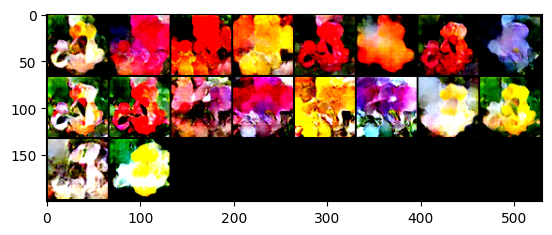

100%|██████████| 103/103 [00:33<00:00,  3.04it/s]


epoch: 17, lossD:1.9118910865876282, lossG:2.3105252738137847,lossG_fake:1.2075244101505835, lossG_real:1.1030008723434892 ,equality:0.10452353780709434


evaluate:124.99144744873047,kid_mean:0.08680055290460587, kid_std:0.03964477777481079,kid_:(tensor(0.0868), tensor(0.0396))


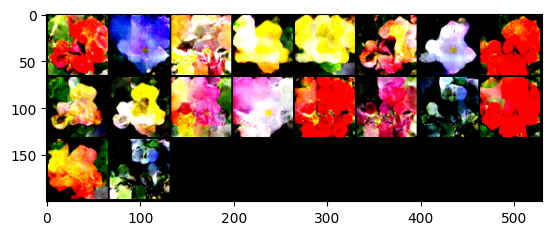

100%|██████████| 103/103 [00:33<00:00,  3.04it/s]


epoch: 18, lossD:1.8687796523270097, lossG:2.279006008962983,lossG_fake:1.170574858929347, lossG_real:1.1084311482975784 ,equality:0.0621437106317686


evaluate:125.87244415283203,kid_mean:0.08685827255249023, kid_std:0.0392862893640995,kid_:(tensor(0.0869), tensor(0.0393))


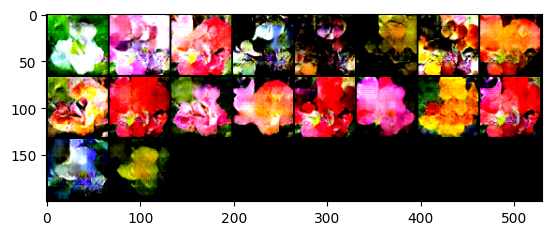

100%|██████████| 103/103 [00:33<00:00,  3.04it/s]


epoch: 19, lossD:1.867480339355839, lossG:2.3097295228717396,lossG_fake:1.2048198922166546, lossG_real:1.1049096242895404 ,equality:0.09991026792711422


evaluate:126.65585327148438,kid_mean:0.08079183846712112, kid_std:0.038010284304618835,kid_:(tensor(0.0808), tensor(0.0380))


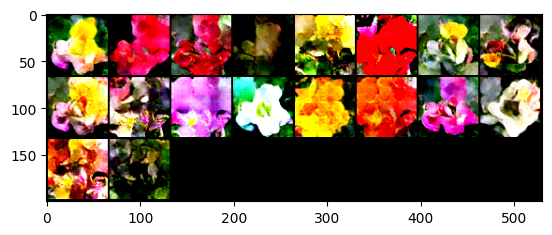

100%|██████████| 103/103 [00:33<00:00,  3.04it/s]


epoch: 20, lossD:1.8620939405219068, lossG:2.3236619592870325,lossG_fake:1.1986388002784507, lossG_real:1.1250231630593828 ,equality:0.07361563721906794


evaluate:127.92008972167969,kid_mean:0.08437973260879517, kid_std:0.04845264181494713,kid_:(tensor(0.0844), tensor(0.0485))


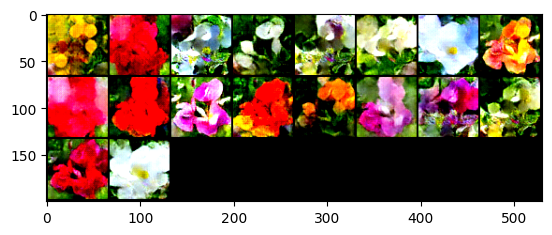

100%|██████████| 103/103 [00:33<00:00,  3.04it/s]


epoch: 21, lossD:2.1242058010934626, lossG:2.3533590719537827,lossG_fake:1.2355623494074182, lossG_real:1.1177967150234482 ,equality:0.11776563438396992


evaluate:128.14805603027344,kid_mean:0.08661714196205139, kid_std:0.04024610295891762,kid_:(tensor(0.0866), tensor(0.0402))


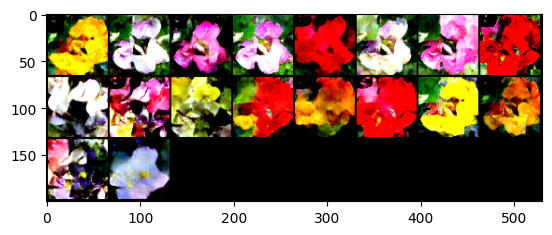

100%|██████████| 103/103 [00:33<00:00,  3.04it/s]


epoch: 22, lossD:1.8886808596768425, lossG:2.193805988552501,lossG_fake:1.1282796350497644, lossG_real:1.065526361025653 ,equality:0.06275327402411146


evaluate:131.73072814941406,kid_mean:0.09137636423110962, kid_std:0.04514317959547043,kid_:(tensor(0.0914), tensor(0.0451))


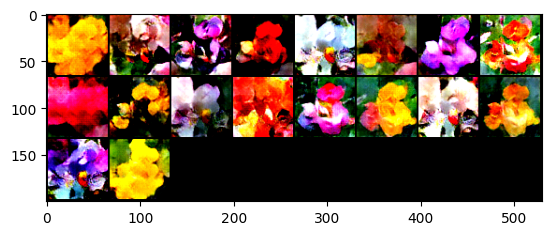

100%|██████████| 103/103 [00:33<00:00,  3.05it/s]


epoch: 23, lossD:1.8644987159562343, lossG:2.2779471897384496,lossG_fake:1.168792400545287, lossG_real:1.1091547758833875 ,equality:0.05963762466189948


evaluate:130.26866149902344,kid_mean:0.09451742470264435, kid_std:0.050195641815662384,kid_:(tensor(0.0945), tensor(0.0502))


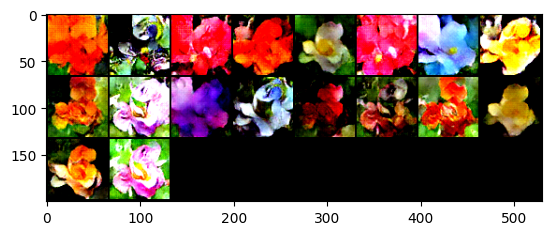

100%|██████████| 103/103 [00:33<00:00,  3.05it/s]


epoch: 24, lossD:1.8590508282763287, lossG:2.3215694473785105,lossG_fake:1.2079017162322998, lossG_real:1.1136677351970117 ,equality:0.09423398103528813


evaluate:129.44482421875,kid_mean:0.09470700472593307, kid_std:0.045367177575826645,kid_:(tensor(0.0947), tensor(0.0454))


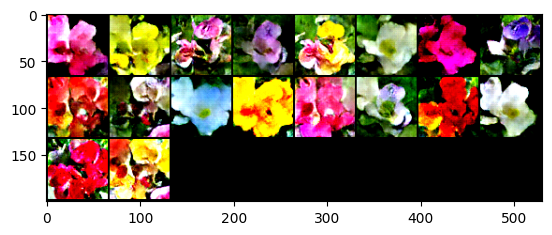

100%|██████████| 103/103 [00:33<00:00,  3.05it/s]


epoch: 25, lossD:1.8483296447587245, lossG:2.350856637491763,lossG_fake:1.2136837822719686, lossG_real:1.1371728621640251 ,equality:0.07651092010794347


evaluate:131.22434997558594,kid_mean:0.08610469847917557, kid_std:0.037699803709983826,kid_:(tensor(0.0861), tensor(0.0377))


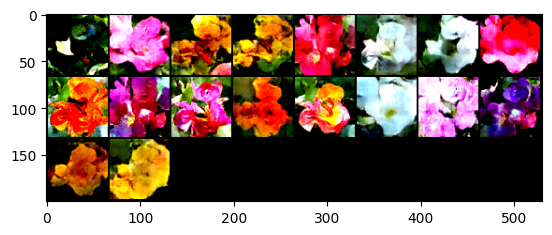

100%|██████████| 103/103 [00:33<00:00,  3.06it/s]


epoch: 26, lossD:2.088262547567053, lossG:2.285130815598571,lossG_fake:1.1925963875159478, lossG_real:1.0925344280826235 ,equality:0.1000619594333243


evaluate:130.1487579345703,kid_mean:0.09761568903923035, kid_std:0.050416309386491776,kid_:(tensor(0.0976), tensor(0.0504))


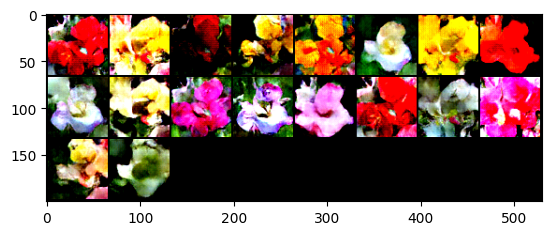

100%|██████████| 103/103 [00:33<00:00,  3.05it/s]


epoch: 27, lossD:1.8796516807333936, lossG:2.22993389379631,lossG_fake:1.139890995997827, lossG_real:1.0900428954837391 ,equality:0.049848100514087834


evaluate:131.49798583984375,kid_mean:0.09267494827508926, kid_std:0.046504732221364975,kid_:(tensor(0.0927), tensor(0.0465))


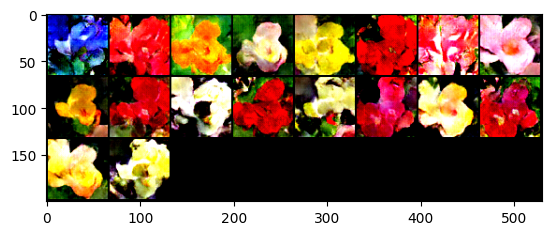

100%|██████████| 103/103 [00:33<00:00,  3.04it/s]


epoch: 28, lossD:1.9947055011119657, lossG:2.4005076630601607,lossG_fake:1.2328879370272738, lossG_real:1.1676197260328867 ,equality:0.06526821099438718


evaluate:134.0016326904297,kid_mean:0.09259855002164841, kid_std:0.045880381017923355,kid_:(tensor(0.0926), tensor(0.0459))


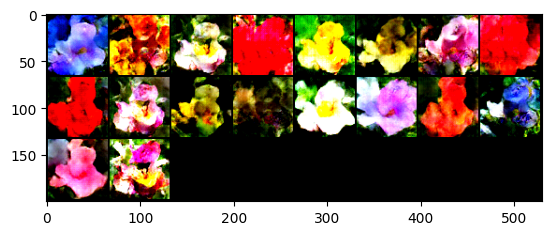

100%|██████████| 103/103 [00:33<00:00,  3.05it/s]


epoch: 29, lossD:1.9494954382331626, lossG:2.1480266260869296,lossG_fake:1.0902652416414427, lossG_real:1.0577613751865127 ,equality:0.032503866454929975


evaluate:133.65675354003906,kid_mean:0.10238546133041382, kid_std:0.049401506781578064,kid_:(tensor(0.1024), tensor(0.0494))


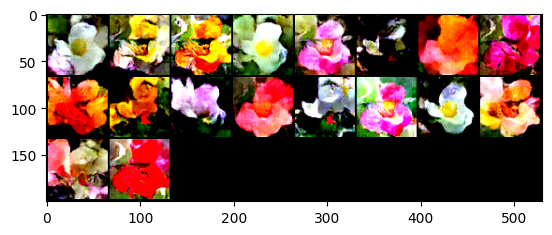

100%|██████████| 103/103 [00:33<00:00,  3.04it/s]


epoch: 30, lossD:1.8508548111591525, lossG:2.2881744231992553,lossG_fake:1.1814585449626145, lossG_real:1.1067158753432116 ,equality:0.0747426696194029


evaluate:133.24769592285156,kid_mean:0.08838299661874771, kid_std:0.039507102221250534,kid_:(tensor(0.0884), tensor(0.0395))


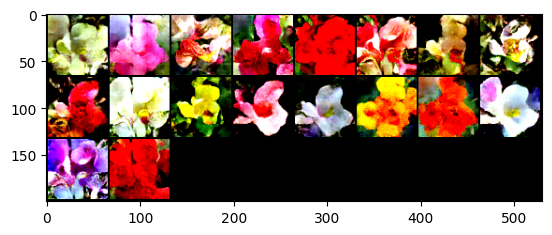

100%|██████████| 103/103 [00:33<00:00,  3.05it/s]


epoch: 31, lossD:1.8509164099554414, lossG:2.3502564569121427,lossG_fake:1.2023733449213714, lossG_real:1.1478831206710594 ,equality:0.054490224250312025


evaluate:132.38650512695312,kid_mean:0.09732014685869217, kid_std:0.0416969396173954,kid_:(tensor(0.0973), tensor(0.0417))


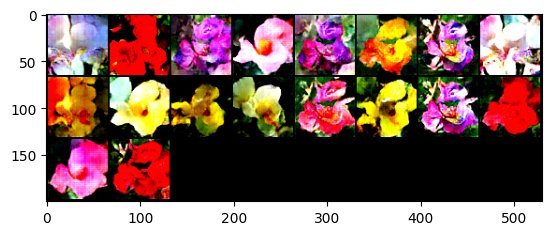

100%|██████████| 103/103 [00:33<00:00,  3.04it/s]


epoch: 32, lossD:1.8291506778846667, lossG:2.376026933633008,lossG_fake:1.2241870205379226, lossG_real:1.151839904993483 ,equality:0.07234711554443951


evaluate:131.9842987060547,kid_mean:0.10084716975688934, kid_std:0.04066301882266998,kid_:(tensor(0.1008), tensor(0.0407))


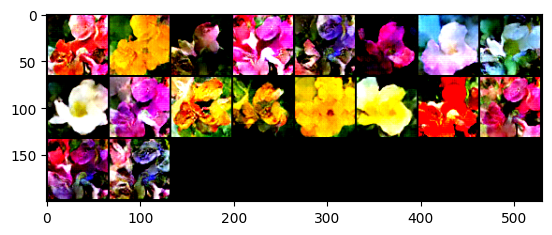

100%|██████████| 103/103 [00:33<00:00,  3.04it/s]


epoch: 33, lossD:1.9025662049506475, lossG:2.418066918271259,lossG_fake:1.2456673597826542, lossG_real:1.1723995521230606 ,equality:0.07326780765959362


evaluate:132.45777893066406,kid_mean:0.1001630425453186, kid_std:0.043466802686452866,kid_:(tensor(0.1002), tensor(0.0435))


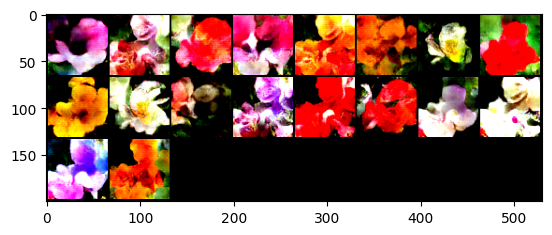

100%|██████████| 103/103 [00:33<00:00,  3.04it/s]


epoch: 34, lossD:1.8315002709916495, lossG:2.333451201614824,lossG_fake:1.19833837782295, lossG_real:1.135112829578733 ,equality:0.063225548244217


evaluate:131.1407012939453,kid_mean:0.0919746458530426, kid_std:0.04199586436152458,kid_:(tensor(0.0920), tensor(0.0420))


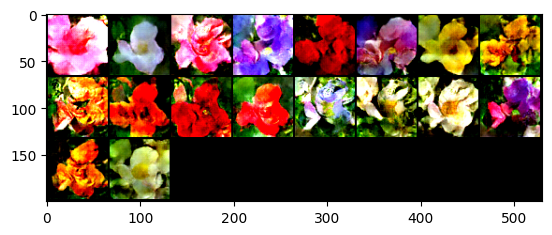

100%|██████████| 103/103 [00:33<00:00,  3.05it/s]


epoch: 35, lossD:1.8213523394853166, lossG:2.4125143185402584,lossG_fake:1.2401358606745896, lossG_real:1.1723784596017264 ,equality:0.06775740107286321


evaluate:130.98171997070312,kid_mean:0.0961945652961731, kid_std:0.050056952983140945,kid_:(tensor(0.0962), tensor(0.0501))


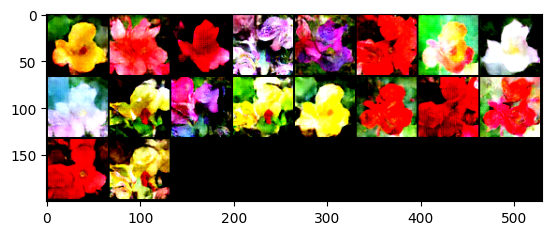

100%|██████████| 103/103 [00:33<00:00,  3.04it/s]


epoch: 36, lossD:1.832381888500695, lossG:2.397478726303693,lossG_fake:1.227344752515404, lossG_real:1.170133974945661 ,equality:0.05721077756974302


evaluate:130.74949645996094,kid_mean:0.09305689483880997, kid_std:0.042461395263671875,kid_:(tensor(0.0931), tensor(0.0425))


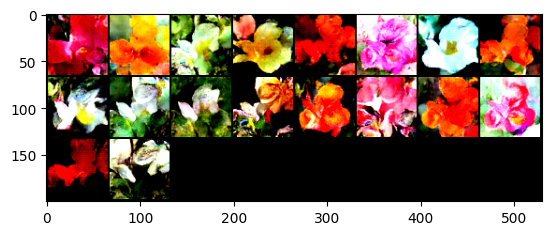

100%|██████████| 103/103 [00:33<00:00,  3.04it/s]


epoch: 37, lossD:1.8611649355842073, lossG:2.401176549855945,lossG_fake:1.23460466364055, lossG_real:1.1665718891088246 ,equality:0.06803277453172552


evaluate:130.36019897460938,kid_mean:0.09175565093755722, kid_std:0.04264339059591293,kid_:(tensor(0.0918), tensor(0.0426))


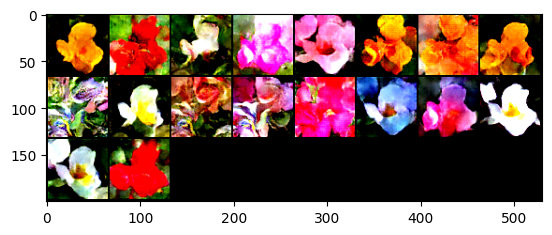

100%|██████████| 103/103 [00:33<00:00,  3.04it/s]


epoch: 38, lossD:1.8156896760162797, lossG:2.4311680446550685,lossG_fake:1.2599619922128695, lossG_real:1.1712060501274553 ,equality:0.08875594208541426


evaluate:131.3037567138672,kid_mean:0.09135860204696655, kid_std:0.044263921678066254,kid_:(tensor(0.0914), tensor(0.0443))


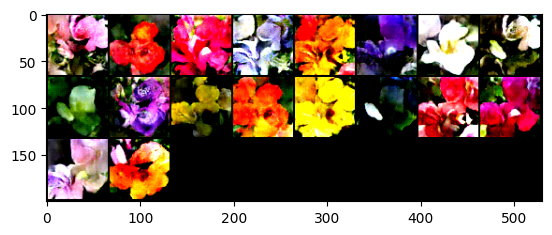

100%|██████████| 103/103 [00:33<00:00,  3.04it/s]


epoch: 39, lossD:1.789282338133136, lossG:2.4797778175872507,lossG_fake:1.2887869112699935, lossG_real:1.190990902266456 ,equality:0.09779600900353747


evaluate:130.28794860839844,kid_mean:0.08331989496946335, kid_std:0.03972168639302254,kid_:(tensor(0.0833), tensor(0.0397))


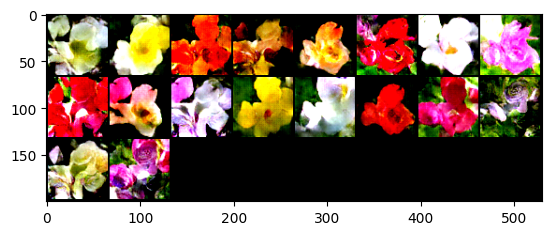

100%|██████████| 103/103 [00:33<00:00,  3.05it/s]


epoch: 40, lossD:1.7906616567407998, lossG:2.5146373383049827,lossG_fake:1.292992178097512, lossG_real:1.2216451578927272 ,equality:0.07134702020478478


evaluate:130.83216857910156,kid_mean:0.09538282454013824, kid_std:0.04697726294398308,kid_:(tensor(0.0954), tensor(0.0470))


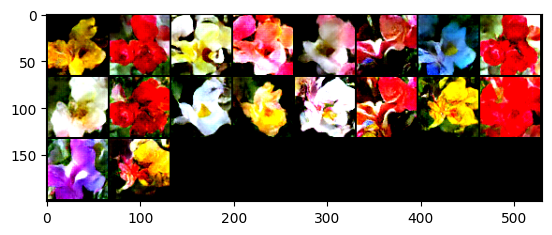

100%|██████████| 103/103 [00:33<00:00,  3.05it/s]


epoch: 41, lossD:1.7824637658387712, lossG:2.5123616283379713,lossG_fake:1.3063973755512424, lossG_real:1.2059642452638126 ,equality:0.10043313028742973


evaluate:130.0955810546875,kid_mean:0.08725866675376892, kid_std:0.042668431997299194,kid_:(tensor(0.0873), tensor(0.0427))


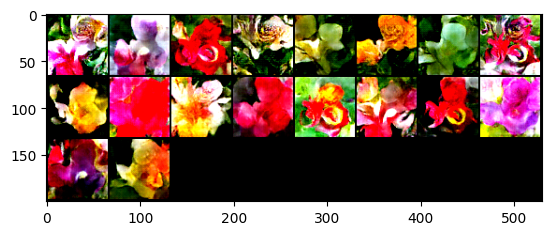

100%|██████████| 103/103 [00:33<00:00,  3.05it/s]


epoch: 42, lossD:1.7614905243938408, lossG:2.5260739905162923,lossG_fake:1.3041844286964934, lossG_real:1.2218895583476834 ,equality:0.08229487034881


evaluate:130.30715942382812,kid_mean:0.09440355002880096, kid_std:0.03865276277065277,kid_:(tensor(0.0944), tensor(0.0387))


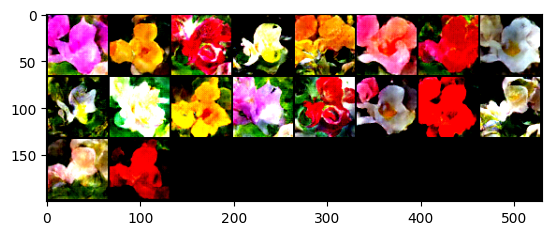

100%|██████████| 103/103 [00:33<00:00,  3.05it/s]


epoch: 43, lossD:1.7472590613133698, lossG:2.5504218791295026,lossG_fake:1.3130506751606765, lossG_real:1.2373711999180248 ,equality:0.07567947524265173


evaluate:129.04104614257812,kid_mean:0.08978473395109177, kid_std:0.04110870882868767,kid_:(tensor(0.0898), tensor(0.0411))


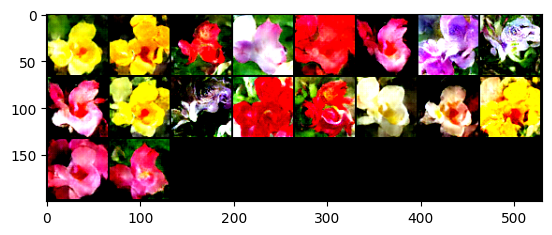

100%|██████████| 103/103 [00:33<00:00,  3.05it/s]


epoch: 44, lossD:1.7413323446384912, lossG:2.578397350403869,lossG_fake:1.3256106856957222, lossG_real:1.2527866797539795 ,equality:0.07282400594174265


evaluate:128.49795532226562,kid_mean:0.08177188783884048, kid_std:0.0436382070183754,kid_:(tensor(0.0818), tensor(0.0436))


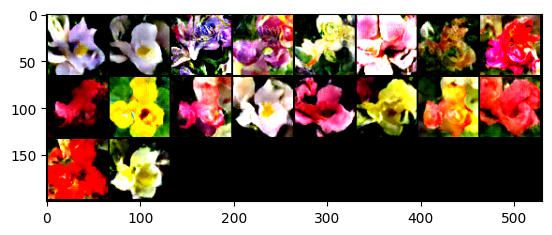

100%|██████████| 103/103 [00:33<00:00,  3.05it/s]


epoch: 45, lossD:1.7493950093834145, lossG:2.5993962588819484,lossG_fake:1.3343444779081253, lossG_real:1.2650517850246243 ,equality:0.06929269288350093


evaluate:127.69971466064453,kid_mean:0.09392673522233963, kid_std:0.04454585537314415,kid_:(tensor(0.0939), tensor(0.0445))


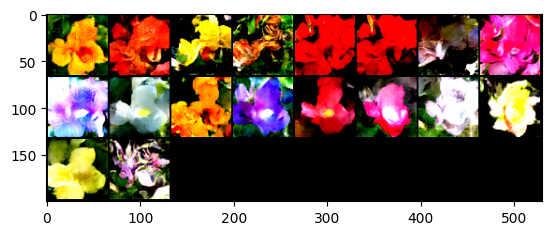

100%|██████████| 103/103 [00:33<00:00,  3.06it/s]


epoch: 46, lossD:1.7932849404881301, lossG:2.6001025750799087,lossG_fake:1.3391056552674006, lossG_real:1.2609969192338222 ,equality:0.07810873603357837


evaluate:127.29154205322266,kid_mean:0.09001459181308746, kid_std:0.04774245619773865,kid_:(tensor(0.0900), tensor(0.0477))


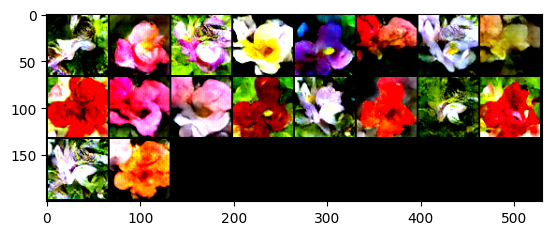

100%|██████████| 103/103 [00:33<00:00,  3.05it/s]


epoch: 47, lossD:1.6920592588128396, lossG:2.6174053474537375,lossG_fake:1.339707703845015, lossG_real:1.2776976389792358 ,equality:0.06201006486577909


evaluate:128.4428253173828,kid_mean:0.08927282691001892, kid_std:0.03812028467655182,kid_:(tensor(0.0893), tensor(0.0381))


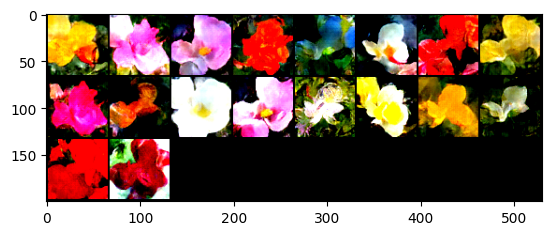

100%|██████████| 103/103 [00:33<00:00,  3.04it/s]


epoch: 48, lossD:1.7514358955679588, lossG:2.6481415600452607,lossG_fake:1.3623594225031659, lossG_real:1.285782146222383 ,equality:0.07657727628078281


evaluate:127.87081909179688,kid_mean:0.09179392457008362, kid_std:0.04147816449403763,kid_:(tensor(0.0918), tensor(0.0415))


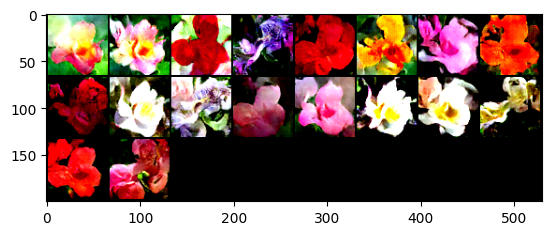

100%|██████████| 103/103 [00:33<00:00,  3.04it/s]


epoch: 49, lossD:1.669616176086722, lossG:2.6879204546363606,lossG_fake:1.379941563004429, lossG_real:1.3079788997335342 ,equality:0.07196266327089473


evaluate:128.8124542236328,kid_mean:0.07972646504640579, kid_std:0.040753044188022614,kid_:(tensor(0.0797), tensor(0.0408))


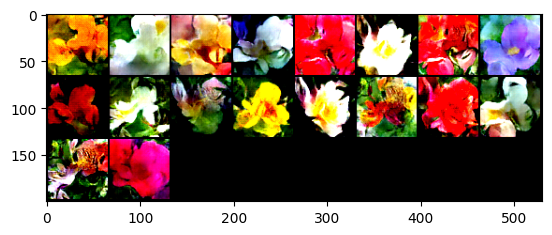

In [ ]:
lossesD = []
lossesG = []

raw_lossesD = []
raw_lossesG = []
lossesG_fake = []
lossesG_real = []

equality = 0.0
sum_equality = 0.0
d_equality = []

relu = torch.nn.ReLU()

fid_ = []
kid_mean_ = []
kid_std_ = []
kid_score = []
for epoch in range(opt.n_epoch):
    running_lossD = 0.0 #損失関数初期化
    running_lossG = 0.0
    lossG_fake_running = 0.0
    lossG_real_running = 0.0

    #sum_equality += equality
    equality = 0.0
   # for i , (real_imgs, _) in enumerate(tqdm.tqdm(dataloader, position = 0)):#celebA
    for i , real_imgs in enumerate(tqdm.tqdm(dataloader, position = 0)):#flower
        real_imgs = real_imgs.to(device)
        batch_size = real_imgs.size()[0]
        noise = torch.randn(batch_size, opt.z_dim, 1, 1).to(device)

        #train discriminator

        netD.zero_grad()
        output_real = netD(real_imgs)

        #lossD_real = criterion(output, labels_real)
        lossD_real = torch.mean(relu(1.0 - output_real))


        fake_imgs = netG(noise)##not train  output_fake_d
        output_fake_d = netD(fake_imgs.detach())#not train  output_fake_d

        #lossD_fake = criterion(output, labels_fake)
        lossD_fake = torch.mean(relu(1.0 + output_fake_d))


        lossD = lossD_real + lossD_fake
        #lossD = torch.mean(torch.log(torch.sigmoid(output_real)))- torch.mean(torch.log(torch.sigmoid(output_fake_d)))  #not train  output_fake_d
        lossD.backward()
        optimizerD.step()

        #train generator

        netG.zero_grad()#勾配初期

        output_fake_g = netD(fake_imgs)#train  output_fake_g
        output_real = netD(real_imgs)

        lossG_fake = torch.mean(relu(1.0 - output_fake_g))
        lossG_real = torch.mean(relu(1.0 + output_real))
        #lossG =  torch.mean(torch.log(torch.sigmoid(output_fake_g - output_real))) #- torch.mean(torch.log(torch.sigmoid(output_real)))#train  output_fake_g
        lossG =    lossG_real + lossG_fake


        lossG.backward()
        optimizerG.step()

        # save loss

        running_lossD += lossD.item()
        running_lossG += lossG.item()

        raw_lossesD.append(lossD.item())
        raw_lossesG.append(lossG.item())

        lossG_fake_running += lossG_fake.item()
        lossG_real_running += lossG_real.item()



    running_lossD /=len(dataloader)
    running_lossG /=len(dataloader)

    lossG_fake_running /= len(dataloader)
    lossG_real_running /= len(dataloader)
#equality
    equality = ( lossG_fake_running - lossG_real_running  )
    d_equality.append(equality)


    print("epoch: {}, lossD:{}, lossG:{},lossG_fake:{}, lossG_real:{} ,equality:{}".format(epoch, running_lossD, running_lossG,lossG_fake_running,lossG_real_running,equality))#-->,lossG_fake:{}, lossG_real:{},lossG_fake_running,lossG_real_running
    lossesD.append(running_lossD)
    lossesG.append(running_lossG)

    lossesG_fake.append(lossG_fake_running)
    lossesG_real.append(lossG_real_running)

     #evaluate GAN
    fake_imgs_1 = fake_imgs.detach()
    real_imgs_1 = real_imgs.to(dtype=torch.uint8).cpu()
    fake_imgs_1 = fake_imgs_1.to(dtype=torch.uint8).cpu()
    fid.update(real_imgs_1, real=True)
    fid.update(fake_imgs_1, real=False)
    eval = fid.compute()

    kid.update(real_imgs_1, real=True)
    kid.update(fake_imgs_1, real=False)
    kid_ = kid.compute()
    kid_mean, kid_std = kid.compute()



    print("evaluate:{},kid_mean:{}, kid_std:{},kid_:{}".format(eval, kid_mean, kid_std, kid_))
    fid_.append(eval)
    kid_mean_.append(kid_mean)
    kid_std_.append(kid_std)
    kid_score.append(kid_)
    #show fake image
    grid_imgs = vutils.make_grid(fake_imgs[:24].detach()+0.5)
    grid_imgs_arr = grid_imgs.cpu().numpy()
    plt.imshow(np.transpose(grid_imgs_arr, (1,2,0)))
    plt.show()

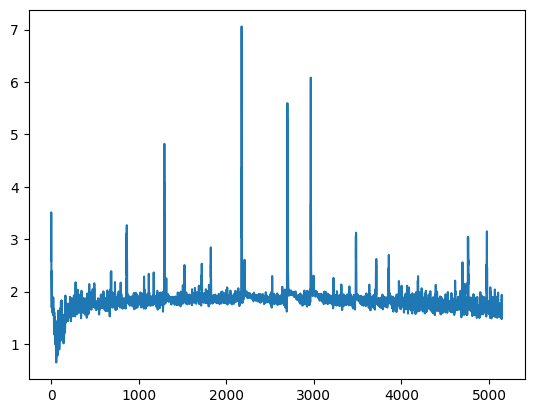

In [ ]:
plt.plot(raw_lossesD)

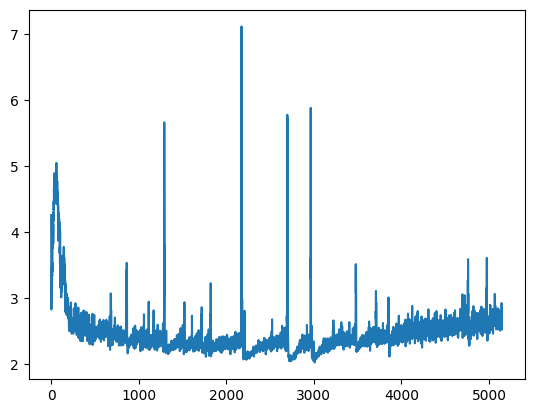

In [ ]:
plt.plot(raw_lossesG)

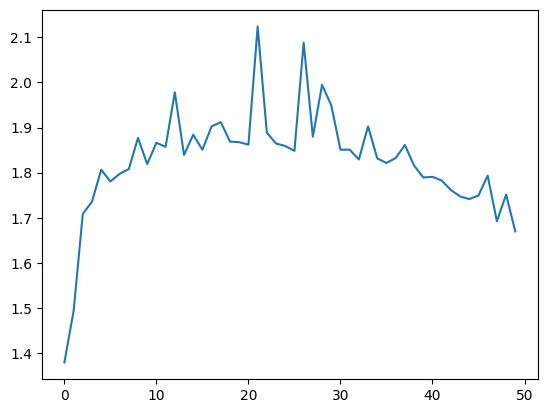

In [ ]:
plt.plot(lossesD)

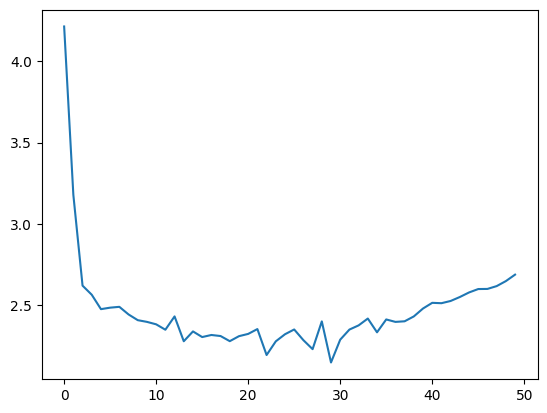

In [ ]:
plt.plot(lossesG)

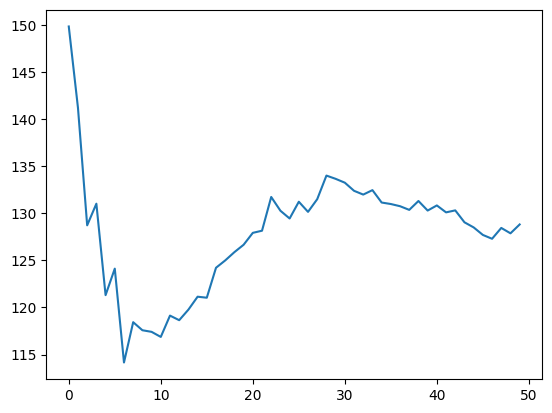

In [ ]:
plt.plot(fid_)

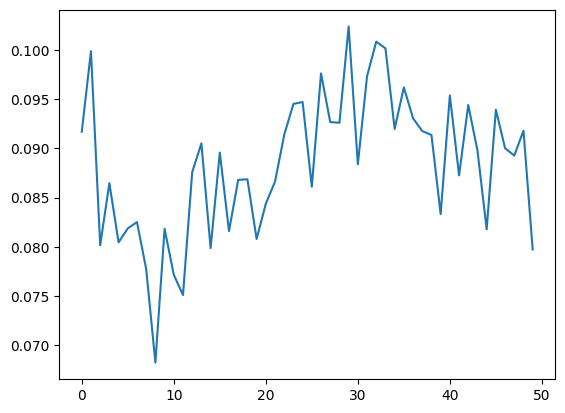

In [ ]:
plt.plot(kid_mean_)

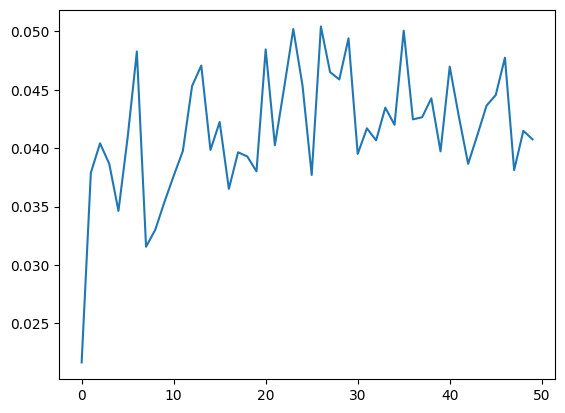

In [ ]:
plt.plot(kid_std_)

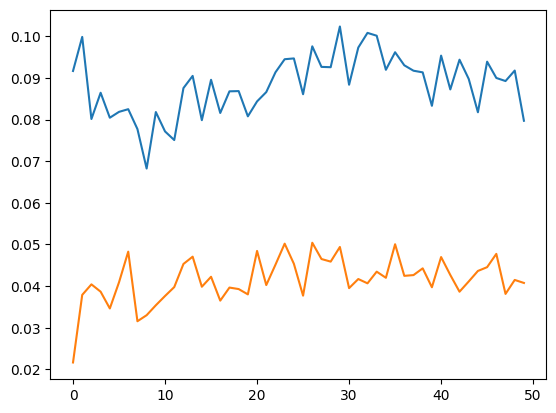

In [ ]:
plt.plot(kid_score)

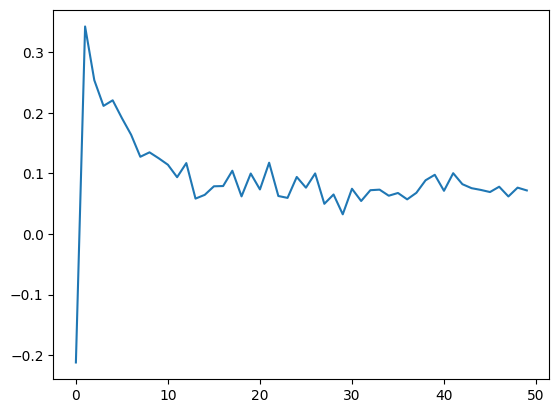

In [ ]:
plt.plot(d_equality)

In [ ]:

real_imgs = real_imgs.to(dtype=torch.uint8).cpu()
fake_imgs = fake_imgs.to(dtype=torch.uint8).cpu()
fid.update(real_imgs, real=True)
fid.update(fake_imgs, real=False)
fid.compute()

kid.update(real_imgs, real=True)
kid.update(fake_imgs, real=False)
kid.compute()

(tensor(0.0907), tensor(0.0474))